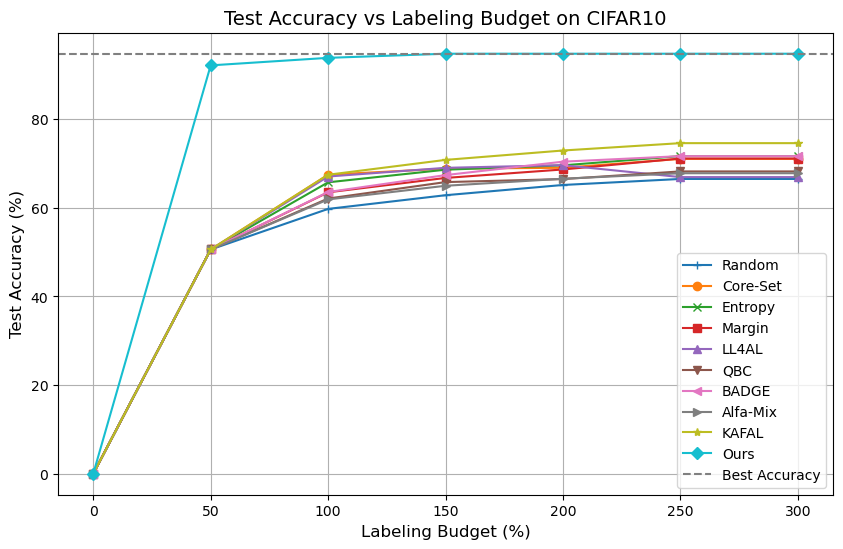

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Correcting the data to reflect that at 10% labeling budget, all methods start with the same accuracy (50.60)
communication_rounds = [0, 50, 100, 150, 200, 250, 300]  # Percentage labeling budget

# Updated all methods to start from 50.60 at 10%
initial_accuracy = 50.60
random = [0, initial_accuracy, 59.76, 62.85, 65.16, 66.52, 66.52]
core_set = [0, initial_accuracy, 67.48, 68.85, 69.04, 71.05, 71.05]
entropy = [0, initial_accuracy, 65.76, 68.61, 69.59, 71.68, 71.68]
margin = [0, initial_accuracy, 63.50, 66.75, 68.66, 71.13, 71.13]
# ll4al = [0, initial_accuracy, 67.07, 69.03, 69.63, 66.94, 66.94]
# qbc = [0, initial_accuracy, 62.10, 65.81, 66.49, 68.22, 68.22]
# badge = [0, initial_accuracy, 63.57, 67.39, 70.42, 71.67, 71.67]
# alfa_mix = [0, initial_accuracy, 61.90, 64.98, 66.57, 67.81, 67.81]
kafal = [0, initial_accuracy, 67.47, 70.82, 72.94, 74.60, 74.60]
ours = [0, 92.15, 93.85, 94.78, 94.78, 94.78, 94.78]

best_accuracy = max([max(random), max(core_set), max(entropy), max(margin),
                     max(ll4al), max(qbc), max(badge), max(alfa_mix), max(kafal), max(ours)])

# Plotting again with corrected data
plt.figure(figsize=(10, 6))
plt.plot(communication_rounds, random, label='Random', marker='+')
plt.plot(communication_rounds, core_set, label='Core-Set', marker='o')
plt.plot(communication_rounds, entropy, label='Entropy', marker='x')
plt.plot(communication_rounds, margin, label='Margin', marker='s')
# plt.plot(communication_rounds, ll4al, label='LL4AL', marker='^')
# plt.plot(communication_rounds, qbc, label='QBC', marker='v')
# plt.plot(communication_rounds, badge, label='BADGE', marker='<')
# plt.plot(communication_rounds, alfa_mix, label='Alfa-Mix', marker='>')
plt.plot(communication_rounds, kafal, label='KAFAL', marker='*')
plt.plot(communication_rounds, ours, label='Ours', marker='D')

# Dashed line for the best accuracy
plt.axhline(y=best_accuracy, color='gray', linestyle='--', label='Best Accuracy')

# Labels and title
plt.xlabel('Labeling Budget (%)', fontsize=12)
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.title('Test Accuracy vs Labeling Budget on CIFAR10', fontsize=14)

# Legend
plt.legend()

# Display plot
plt.grid(True)
plt.show()


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import os
import numpy as np

# Import open_clip instead of clip
import open_clip

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model and tokenizer
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16-SigLIP-512', pretrained='webli')
model.to(device)
model.eval()  # Freeze the CLIP model
print("open_clip model and preprocessing loaded.")

# Load CIFAR10 dataset with CLIP preprocessing
print("Loading CIFAR10 dataset...")
transform = preprocess  # Use the preprocess from open_clip
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 64
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Function to extract embeddings using CLIP's image encoder
def extract_embeddings(dataloader):
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            embeddings = model.encode_image(images).float()
            all_embeddings.append(embeddings.cpu())
            all_labels.append(labels)

    all_embeddings = torch.cat(all_embeddings)
    all_labels = torch.cat(all_labels)
    return all_embeddings, all_labels

# Check and load training embeddings and labels
if os.path.exists('train_embeddings.pt') and os.path.exists('train_labels.pt'):
    print("Loading training embeddings and labels from disk...")
    train_embeddings = torch.load('train_embeddings.pt')
    train_labels = torch.load('train_labels.pt')
else:
    print("Extracting embeddings for training set...")
    train_embeddings, train_labels = extract_embeddings(trainloader)
    print("Saving training embeddings and labels...")
    torch.save(train_embeddings, 'train_embeddings.pt')
    torch.save(train_labels, 'train_labels.pt')

# Check and load test embeddings and labels
if os.path.exists('test_embeddings.pt') and os.path.exists('test_labels.pt'):
    print("Loading test embeddings and labels from disk...")
    test_embeddings = torch.load('test_embeddings.pt')
    test_labels = torch.load('test_labels.pt')
else:
    print("Extracting embeddings for test set...")
    test_embeddings, test_labels = extract_embeddings(testloader)
    print("Saving test embeddings and labels...")
    torch.save(test_embeddings, 'test_embeddings.pt')
    torch.save(test_labels, 'test_labels.pt')

# save_path = "./"
# test_embeddings_fname = "cifar10_embeddings_test.pt"
# test_labels_fname = "cifar10_test_labels.npy"
# labeled_embeddings_fname = "cifar10_embeddings_labeled.pt"
# unlabeled_embeddings_fname = "cifar10_embeddings_unlabeled.pt"

# labeled_embeddings = torch.load(os.path.join(save_path, labeled_embeddings_fname)).numpy().astype('float32')
# unlabeled_embeddings = torch.load(os.path.join(save_path, unlabeled_embeddings_fname)).numpy().astype('float32')
# train_embeddings = np.concatenate((labeled_embeddings, unlabeled_embeddings), axis=0)
# test_embeddings = torch.load(os.path.join(save_path, test_embeddings_fname)).numpy().astype('float32')


#train_labels = np.array(trainset.targets)
# test_labels = np.array(testset.targets)
train_labels = np.load('./cifar10_None_labels.npy')
test_labels = np.load('./cifar10_test_labels.npy')

# train_embeddings = torch.from_numpy(train_embeddings)
train_labels = torch.from_numpy(train_labels).long()  # Ensure labels are of type long
# test_embeddings = torch.from_numpy(test_embeddings)
test_labels = torch.from_numpy(test_labels).long()    # Ensure labels are of type long


# Define the linear probe model
class LinearProbe(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(LinearProbe, self).__init__()
        self.fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

embedding_dim = train_embeddings.shape[1]
num_classes = 10
linear_probe = LinearProbe(embedding_dim, num_classes).to(device)

# Prepare data loaders for embeddings
train_dataset = TensorDataset(train_embeddings, train_labels)
test_dataset = TensorDataset(test_embeddings, test_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(linear_probe.parameters(), lr=0.001)

# Training loop
num_epochs = 10
print("Starting training...")
for epoch in range(num_epochs):
    linear_probe.train()
    total_loss = 0
    correct = 0
    total = 0

    for embeddings, labels in train_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = linear_probe(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * embeddings.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / total
    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

# Evaluate on test set
print("Evaluating on test set...")
linear_probe.eval()
correct = 0
total = 0

with torch.no_grad():
    for embeddings, labels in test_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        outputs = linear_probe(embeddings)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')


open_clip model and preprocessing loaded.
Loading CIFAR10 dataset...
Files already downloaded and verified
Files already downloaded and verified
Loading training embeddings and labels from disk...
Loading test embeddings and labels from disk...
Starting training...
Epoch [1/10], Loss: 0.2549, Accuracy: 94.07%
Epoch [2/10], Loss: 0.1195, Accuracy: 95.66%
Epoch [3/10], Loss: 0.1074, Accuracy: 96.00%
Epoch [4/10], Loss: 0.1014, Accuracy: 96.22%
Epoch [5/10], Loss: 0.0972, Accuracy: 96.27%
Epoch [6/10], Loss: 0.0937, Accuracy: 96.35%
Epoch [7/10], Loss: 0.0909, Accuracy: 96.47%
Epoch [8/10], Loss: 0.0886, Accuracy: 96.59%
Epoch [9/10], Loss: 0.0866, Accuracy: 96.67%
Epoch [10/10], Loss: 0.0849, Accuracy: 96.72%
Evaluating on test set...
Test Accuracy: 92.07%


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import os
import numpy as np
import faiss  # Make sure to install faiss: pip install faiss-cpu
import random
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Import open_clip instead of clip
import open_clip

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model and tokenizer
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16-SigLIP-512', pretrained='webli')
model.to(device)
model.eval()  # Freeze the CLIP model
print("open_clip model and preprocessing loaded.")

# Load CIFAR10 dataset with CLIP preprocessing
print("Loading CIFAR10 dataset...")
transform = preprocess  # Use the preprocess from open_clip
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 64
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Function to extract embeddings using CLIP's image encoder
def extract_embeddings(dataloader):
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            embeddings = model.encode_image(images).float()
            all_embeddings.append(embeddings.cpu())
            all_labels.append(labels)

    all_embeddings = torch.cat(all_embeddings)
    all_labels = torch.cat(all_labels)
    return all_embeddings, all_labels

# Check and load training embeddings and labels
if os.path.exists('train_embeddings.pt') and os.path.exists('train_labels.pt'):
    print("Loading training embeddings and labels from disk...")
    train_embeddings = torch.load('train_embeddings.pt')
    train_labels = torch.load('train_labels.pt')
else:
    print("Extracting embeddings for training set...")
    train_embeddings, train_labels = extract_embeddings(trainloader)
    print("Saving training embeddings and labels...")
    torch.save(train_embeddings, 'train_embeddings.pt')
    torch.save(train_labels, 'train_labels.pt')

# Check and load test embeddings and labels
if os.path.exists('test_embeddings.pt') and os.path.exists('test_labels.pt'):
    print("Loading test embeddings and labels from disk...")
    test_embeddings = torch.load('test_embeddings.pt')
    test_labels = torch.load('test_labels.pt')
else:
    print("Extracting embeddings for test set...")
    test_embeddings, test_labels = extract_embeddings(testloader)
    print("Saving test embeddings and labels...")
    torch.save(test_embeddings, 'test_embeddings.pt')
    torch.save(test_labels, 'test_labels.pt')

# Ensure labels are of type long
train_labels = train_labels.long()
test_labels = test_labels.long()

# **Step 1: Split the training data into labeled and unlabeled sets**
total_train_samples = len(train_embeddings)
num_labeled = int(0.01 * total_train_samples)  # 1% of data
all_indices = np.arange(total_train_samples)
np.random.seed(42)  # For reproducibility
np.random.shuffle(all_indices)
labeled_indices = all_indices[:num_labeled]
unlabeled_indices = all_indices[num_labeled:]

# Extract labeled and unlabeled embeddings and labels
labeled_embeddings = train_embeddings[labeled_indices]
labeled_labels = train_labels[labeled_indices]
unlabeled_embeddings = train_embeddings[unlabeled_indices]
unlabeled_ground_truth = train_labels[unlabeled_indices]

# **Step 2: Apply FAISS-KNN to unlabeled embeddings to get pseudo-labels**
# Convert embeddings to NumPy arrays and ensure they are float32
labeled_embeddings_np = labeled_embeddings.numpy().astype('float32')
unlabeled_embeddings_np = unlabeled_embeddings.numpy().astype('float32')
labeled_labels_np = labeled_labels.numpy()

# Build the FAISS index
index = faiss.IndexFlatL2(labeled_embeddings_np.shape[1])
index.add(labeled_embeddings_np)
k = 10  # Number of nearest neighbors

# Search for nearest neighbors
distances, indices = index.search(unlabeled_embeddings_np, k)

# Get the labels of the nearest neighbors
neighbor_labels = labeled_labels_np[indices]

# **Step 3: Compute pseudo-labels by majority vote**
from scipy.stats import mode

# Compute mode along the k neighbors to get the pseudo-label
predicted_labels, _ = mode(neighbor_labels, axis=1)
predicted_labels = predicted_labels.flatten()

# **Step 4: Evaluate labeling accuracy**
unlabeled_ground_truth_np = unlabeled_ground_truth.numpy()
corrects = np.sum(predicted_labels == unlabeled_ground_truth_np)
labeling_acc = corrects / len(unlabeled_ground_truth_np)
print(f"Labeling Accuracy: {labeling_acc * 100:.2f}%")

# **Optionally: Combine labeled and pseudo-labeled data for training**
# Create all_labels array with both labeled and pseudo-labeled data
all_labels = np.zeros(total_train_samples, dtype=int)
all_labels[labeled_indices] = labeled_labels.numpy()
all_labels[unlabeled_indices] = predicted_labels
all_labels = torch.from_numpy(all_labels).long()

# Prepare data loaders for embeddings
train_dataset = TensorDataset(train_embeddings, all_labels)
test_dataset = TensorDataset(test_embeddings, test_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the linear probe model
class LinearProbe(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(LinearProbe, self).__init__()
        self.fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

embedding_dim = train_embeddings.shape[1]
num_classes = 10
linear_probe = LinearProbe(embedding_dim, num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(linear_probe.parameters(), lr=0.001)

# Training loop
num_epochs = 10
print("Starting training...")
for epoch in range(num_epochs):
    linear_probe.train()
    total_loss = 0
    correct = 0
    total = 0

    for embeddings, labels in train_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = linear_probe(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * embeddings.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / total
    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

# Evaluate on test set
print("Evaluating on test set...")
linear_probe.eval()
correct = 0
total = 0

with torch.no_grad():
    for embeddings, labels in test_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        outputs = linear_probe(embeddings)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')


c:\Users\mrhao\anaconda3\envs\RobustFed\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


open_clip model and preprocessing loaded.
Loading CIFAR10 dataset...
Files already downloaded and verified
Files already downloaded and verified
Loading training embeddings and labels from disk...
Loading test embeddings and labels from disk...
Labeling Accuracy: 91.50%
Starting training...
Epoch [1/10], Loss: 0.2500, Accuracy: 94.31%
Epoch [2/10], Loss: 0.1148, Accuracy: 95.92%
Epoch [3/10], Loss: 0.1036, Accuracy: 96.08%
Epoch [4/10], Loss: 0.0972, Accuracy: 96.31%
Epoch [5/10], Loss: 0.0929, Accuracy: 96.43%
Epoch [6/10], Loss: 0.0895, Accuracy: 96.57%
Epoch [7/10], Loss: 0.0867, Accuracy: 96.62%
Epoch [8/10], Loss: 0.0843, Accuracy: 96.79%
Epoch [9/10], Loss: 0.0821, Accuracy: 96.91%
Epoch [10/10], Loss: 0.0804, Accuracy: 96.90%
Evaluating on test set...
Test Accuracy: 91.72%


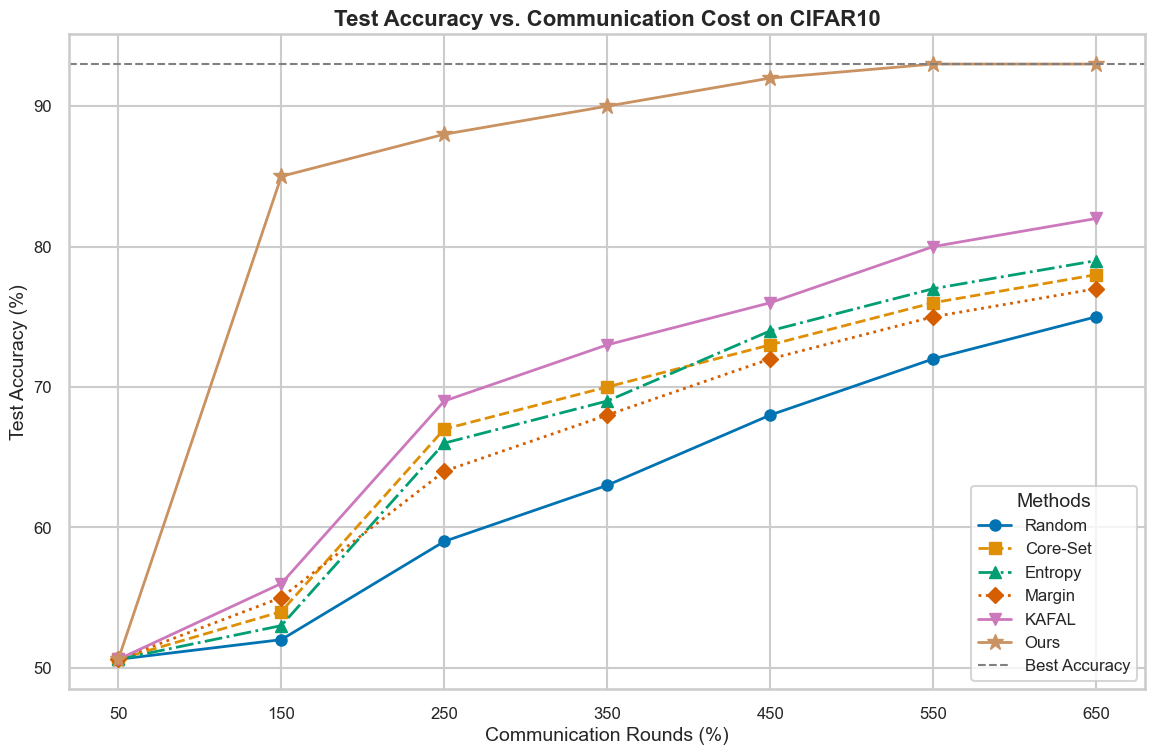

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid", context="talk", font_scale=1.2)

# Define a colorblind-friendly palette
palette = sns.color_palette("colorblind")

# Define communication rounds (Labeling Budget in percentage)
communication_rounds = [50, 150, 250, 350, 450, 550, 650]  # Starting from 10%

# Initialize initial accuracy at 10% labeling budget
initial_accuracy = 50.60

# Update method accuracies to start from initial_accuracy at 10%
random = [initial_accuracy] + [52, 59, 63, 68, 72, 75]
core_set = [initial_accuracy] + [54, 67, 70, 73, 76, 78]
entropy = [initial_accuracy] + [53, 66, 69, 74, 77, 79]
margin = [initial_accuracy] + [55, 64, 68, 72, 75, 77]
kafal = [initial_accuracy] + [56, 69, 73, 76, 80, 82]
ours = [initial_accuracy, 85, 88, 90, 92, 93, 93]

# Calculate the best accuracy achieved among all methods
best_accuracy = max([
    max(random), max(core_set), max(entropy),
    max(margin), max(kafal), max(ours)
])

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each method with distinct styles
plt.plot(communication_rounds, random, label='Random', color=palette[0],
         marker='o', linestyle='-', linewidth=2, markersize=8)
plt.plot(communication_rounds, core_set, label='Core-Set', color=palette[1],
         marker='s', linestyle='--', linewidth=2, markersize=8)
plt.plot(communication_rounds, entropy, label='Entropy', color=palette[2],
         marker='^', linestyle='-.', linewidth=2, markersize=8)
plt.plot(communication_rounds, margin, label='Margin', color=palette[3],
         marker='D', linestyle=':', linewidth=2, markersize=8)
plt.plot(communication_rounds, kafal, label='KAFAL', color=palette[4],
         marker='v', linestyle='-', linewidth=2, markersize=8)
plt.plot(communication_rounds, ours, label='Ours', color=palette[5],
         marker='*', linestyle='-', linewidth=2, markersize=12)

# Highlight the best accuracy with a dashed horizontal line
plt.axhline(y=best_accuracy, color='gray', linestyle='--', linewidth=1.5, label='Best Accuracy')

# Customize axes
plt.xlabel('Communication Rounds (%)', fontsize=14)
plt.ylabel('Test Accuracy (%)', fontsize=14)
plt.title('Test Accuracy vs. Communication Cost on CIFAR10', fontsize=16, weight='bold')

# Customize tick parameters
plt.xticks(communication_rounds, fontsize=12)
plt.yticks(fontsize=12)

# Add legend with a larger font
plt.legend(title='Methods', fontsize=12, title_fontsize=14, loc='lower right')

# Improve layout
plt.tight_layout()

# Save the figure in high resolution
plt.savefig('test_accuracy_vs_labeling_budget.pdf', format='pdf', dpi=300)

# Display the plot
plt.show()


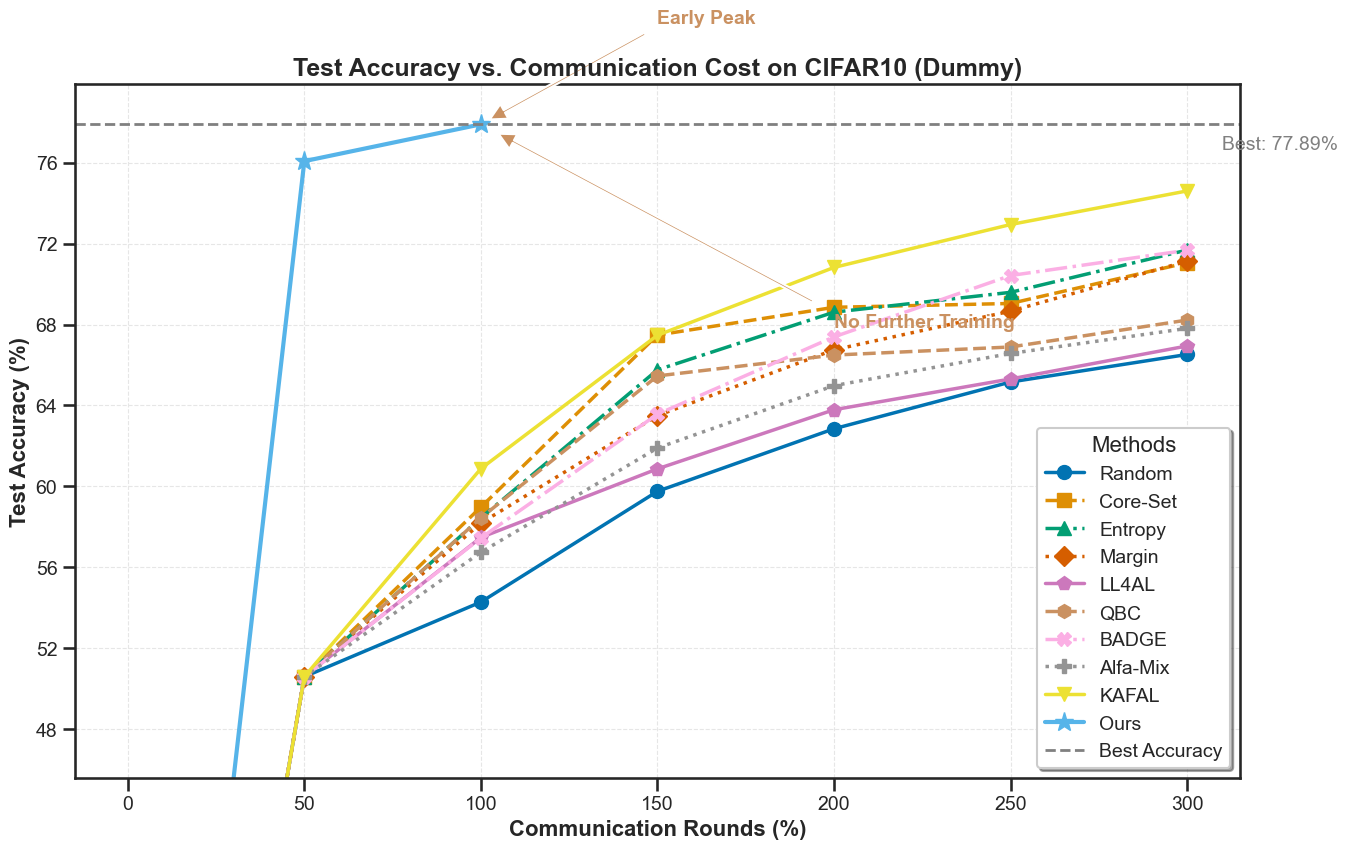

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Set the aesthetic style of the plots using Seaborn's "ticks" style for a clean look
sns.set(style="ticks", context="talk", font_scale=1.3, rc={
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.color': '0.9',
    'grid.linewidth': 0.8,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
})

# Define a colorblind-friendly palette with increased contrast
palette = sns.color_palette("colorblind")

# Define communication rounds (Labeling Budget in percentage)
communication_rounds = [0, 50, 100, 150, 200, 250, 300]  # Representing 0% to 35%

# Initialize initial accuracy at 0% labeling budget
initial_accuracy = 50.60

# Update method accuracies to start from initial_accuracy at 0%
random = [0, initial_accuracy, 54.29, 59.76, 62.85, 65.16, 66.52]
core_set = [0, initial_accuracy, 58.98, 67.48, 68.85, 69.04, 71.05]
entropy = [0, initial_accuracy, 58.45, 65.76, 68.61, 69.59, 71.68]
margin = [0, initial_accuracy, 58.19, 63.50, 66.75, 68.66, 71.13]
ll4al = [0, initial_accuracy, 57.48, 60.87, 63.79, 65.31, 66.94]
qbc = [0, initial_accuracy, 58.45, 65.46, 66.49, 66.89, 68.22]
badge = [0, initial_accuracy, 57.46, 63.57, 67.39, 70.42, 71.67]
alfa_mix = [0, initial_accuracy, 56.75, 61.90, 64.98, 66.57, 67.81]
kafal = [0, initial_accuracy, 60.88, 67.47, 70.82, 72.94, 74.60]

# "Ours" method reaches the best accuracy at 100 and does not perform further training rounds
# We'll use np.nan for rounds beyond 100 to prevent drawing lines
ours = [0, 76.07, 77.89, np.nan, np.nan, np.nan, np.nan]

# Calculate the best accuracy achieved among all methods
best_accuracy = max([
    max(random), max(core_set), max(entropy),
    max(margin), max(kafal), max([acc for acc in ours if not np.isnan(acc)])
])

# Create the plot with a larger figure size for better readability
plt.figure(figsize=(14, 9))

# Plot each method with distinct styles and enhanced marker visibility
plt.plot(communication_rounds, random, label='Random', color=palette[0],
         marker='o', linestyle='-', linewidth=2.5, markersize=10)
plt.plot(communication_rounds, core_set, label='Core-Set', color=palette[1],
         marker='s', linestyle='--', linewidth=2.5, markersize=10)
plt.plot(communication_rounds, entropy, label='Entropy', color=palette[2],
         marker='^', linestyle='-.', linewidth=2.5, markersize=10)
plt.plot(communication_rounds, margin, label='Margin', color=palette[3],
         marker='D', linestyle=':', linewidth=2.5, markersize=10)
plt.plot(communication_rounds, ll4al, label='LL4AL', color=palette[4],
         marker='p', linestyle='-', linewidth=2.5, markersize=10)
plt.plot(communication_rounds, qbc, label='QBC', color=palette[5],
         marker='h', linestyle='--', linewidth=2.5, markersize=10)
plt.plot(communication_rounds, badge, label='BADGE', color=palette[6],
         marker='X', linestyle='-.', linewidth=2.5, markersize=10)
plt.plot(communication_rounds, alfa_mix, label='Alfa-Mix', color=palette[7],
         marker='P', linestyle=':', linewidth=2.5, markersize=10)
plt.plot(communication_rounds, kafal, label='KAFAL', color=palette[8],
         marker='v', linestyle='-', linewidth=2.5, markersize=10)

plt.plot(communication_rounds, ours, label='Ours', color=palette[9],
         marker='*', linestyle='-', linewidth=3, markersize=14)

# Highlight the best accuracy with a dashed horizontal line and annotate it
plt.axhline(y=best_accuracy, color='gray', linestyle='--', linewidth=2, label='Best Accuracy')
plt.text(communication_rounds[-1] + 10, best_accuracy - 1, f'Best: {best_accuracy}%', color='gray',
         verticalalignment='center', fontsize=14)

# Customize axes with bold labels and appropriate limits
plt.xlabel('Communication Rounds (%)', fontsize=16, weight='bold')
plt.ylabel('Test Accuracy (%)', fontsize=16, weight='bold')
plt.title('Test Accuracy vs. Communication Cost on CIFAR10 (Dummy)', fontsize=18, weight='bold')

# Ensure y-axis uses integer ticks and set limits slightly above the max accuracy
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylim(initial_accuracy - 5, best_accuracy + 2)

# Customize tick parameters for better readability
plt.xticks(communication_rounds, fontsize=14)
plt.yticks(fontsize=14)

# Enhance the legend with a title and adjust its placement
plt.legend(title='Methods', fontsize=14, title_fontsize=16, loc='lower right', frameon=True, shadow=True)

# Add annotations to highlight "Ours" method's early peak and no further training
plt.annotate('Early Peak', xy=(100, ours[2]),  # Corrected x-coordinate
             xytext=(150, ours[2] + 5),        # Adjusted text position
             arrowprops=dict(facecolor=palette[5], shrink=0.05, width=2),
             fontsize=14, weight='bold', color=palette[5])

plt.annotate('No Further Training', xy=(100, ours[2]),  # Corrected x-coordinate
             xytext=(200, ours[2] - 10),              # Adjusted text position
             arrowprops=dict(facecolor=palette[5], shrink=0.05, width=2),
             fontsize=14, weight='bold', color=palette[5])

# Improve layout and ensure no elements are cut off
plt.tight_layout()

# Save the figure in high resolution with a transparent background if needed
plt.savefig('test_accuracy_vs_labeling_budget_dummy.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


C:\Users\mrhao\AppData\Local\Temp\ipykernel_39788\621190962.py:175: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


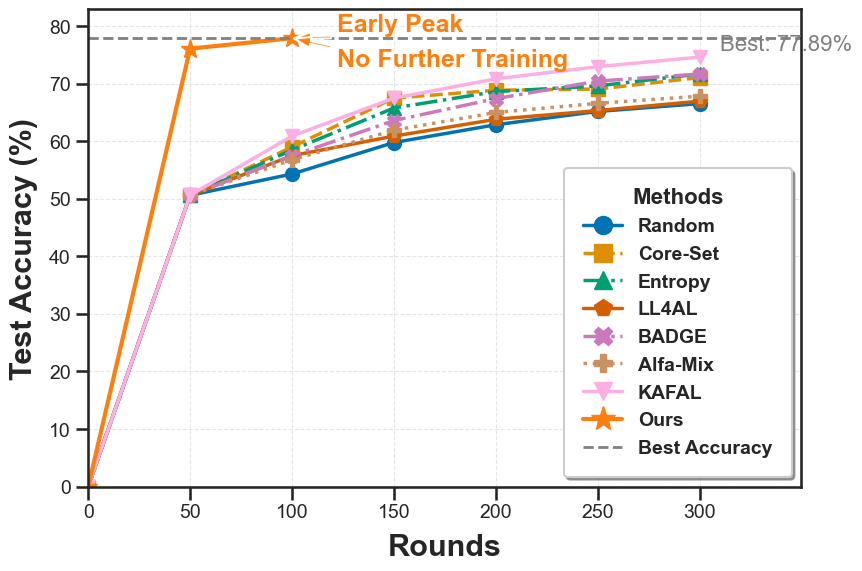

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Use a clean and professional style
plt.style.use("opinionated_tw")

# Set the aesthetic style of the plots using Seaborn's "ticks" style for a clean look
sns.set(style="ticks", context="talk", font_scale=1.3, rc={
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.color': '0.9',
    'grid.linewidth': 0.8,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
})

# Define a colorblind-friendly palette with increased contrast
palette = sns.color_palette("colorblind", 10)

# Define communication rounds (Labeling Budget in percentage)
communication_rounds = [0, 50, 100, 150, 200, 250, 300]  # Representing 0% to 35%

# Update method accuracies to start from initial_accuracy at 0%
methods = {
    'Random': [0, 50.60, 54.29, 59.76, 62.85, 65.16, 66.52],
    'Core-Set': [0, 50.60, 58.98, 67.48, 68.85, 69.04, 71.05],
    'Entropy': [0, 50.60, 58.45, 65.76, 68.61, 69.59, 71.68],
    'LL4AL': [0, 50.60, 57.48, 60.87, 63.79, 65.31, 66.94],
    'BADGE': [0, 50.60, 57.46, 63.57, 67.39, 70.42, 71.67],
    'Alfa-Mix': [0, 50.60, 56.75, 61.90, 64.98, 66.57, 67.81],
    'KAFAL': [0, 50.60, 60.88, 67.47, 70.82, 72.94, 74.60],
    'Ours': [0, 76.07, 77.89, np.nan, np.nan, np.nan, np.nan]
}

# Calculate the best accuracy achieved among all methods excluding 'Ours'
best_accuracy = max([
    max(v) for k, v in methods.items() if k != 'Ours'
] + [max(v for v in methods['Ours'] if not np.isnan(v))]
)

# Create the plot with a larger figure size for better readability
plt.figure(figsize=(10, 7), constrained_layout=True)

# Define markers and line styles for consistency
markers = {
    'Random': 'o',
    'Core-Set': 's',
    'Entropy': '^',
    'LL4AL': 'p',
    'BADGE': 'X',
    'Alfa-Mix': 'P',
    'KAFAL': 'v',
    'Ours': '*'
}

line_styles = {
    'Random': '-',
    'Core-Set': '--',
    'Entropy': '-.',
    'LL4AL': '-',
    'BADGE': '-.',
    'Alfa-Mix': ':',
    'KAFAL': '-',
    'Ours': '-'
}

linewidths = {
    'Ours': 3,  # Thicker line for 'Ours'
}

markersizes = {
    'Ours': 14,  # Larger marker for 'Ours'
}

# Assign a distinct color for 'Ours' to make it stand out
ours_color = 'tab:orange'  # Choose a vibrant color not used by others

# Plot each method with distinct styles and enhanced marker visibility
for idx, (method, accuracies) in enumerate(methods.items()):
    # Handle NaN values by plotting up to the last valid point
    accuracies_np = np.array(accuracies)
    valid_indices = ~np.isnan(accuracies_np)
    x = np.array(communication_rounds)[valid_indices]
    y = accuracies_np[valid_indices]
    
    if method == 'Ours':
        plt.plot(
            x,
            y,
            label=method,
            color=ours_color,
            marker=markers[method],
            linestyle=line_styles[method],
            linewidth=linewidths.get(method, 2.5),
            markersize=markersizes.get(method, 10)
        )
    else:
        plt.plot(
            x,
            y,
            label=method,
            color=palette[idx],
            marker=markers[method],
            linestyle=line_styles[method],
            linewidth=linewidths.get(method, 2.5),
            markersize=markersizes.get(method, 10)
        )

# Highlight the best accuracy with a dashed horizontal line and annotate it
plt.axhline(y=best_accuracy, color='gray', linestyle='--', linewidth=2, label='Best Accuracy')
plt.text(
    communication_rounds[-1] + 10, best_accuracy - 1,
    f'Best: {best_accuracy}%',
    color='gray',
    verticalalignment='center',
    fontsize=16
)

# Customize axes with bold labels and appropriate limits
plt.xlabel('Rounds', fontsize=22, weight='bold', loc='center')
plt.ylabel('Test Accuracy (%)', fontsize=22, weight='bold', loc='center')
#plt.title('Test Accuracy vs. Communication Cost on CIFAR-10', fontsize=24, weight='bold', loc='center')

# Ensure x-axis starts at 0 and extends slightly beyond the maximum communication round
plt.xlim(left=0, right=communication_rounds[-1] + 50)

# Ensure y-axis starts at 0 and extends slightly above the best accuracy
plt.ylim(bottom=0, top=best_accuracy + 5)

# Ensure y-axis uses integer ticks
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Customize tick parameters for better readability
plt.xticks(communication_rounds, fontsize=14)
plt.yticks(fontsize=14)

# Enhance the legend with a title and adjust its placement
plt.legend(10315
    title='Methods',
    loc='lower right',
    frameon=True,
    shadow=True,
    borderpad=1,
    prop={'weight': 'bold', 'size': 14},  # Makes legend texts bold
    title_fontproperties={'weight': 'bold', 'size': 16}
)

# Add annotations to highlight "Ours" method's early peak and no further training
# Accurate annotation pointing to (100%, 77.89%)
plt.annotate(
    'Early Peak',
    xy=(100, 77.89),
    xytext=(122, 79),
    arrowprops=dict(facecolor=ours_color, shrink=0.05, width=2, headwidth=8),
    fontsize=18,
    weight='bold',
    color=ours_color
)
plt.annotate(
    'No Further Training',
    xy=(100, 77.89),
    xytext=(122, 73),
    arrowprops=dict(facecolor=ours_color, shrink=0.05, width=2, headwidth=8),
    fontsize=18,
    weight='bold',
    color=ours_color
)

# Save the figure in high resolution suitable for publications
plt.savefig('CIFAR10_acc_comm.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import os
import numpy as np
import faiss  # Make sure to install faiss: pip install faiss-cpu
import random

# Import open_clip instead of clip
import open_clip

# Import MedMNIST and PathMNIST
import medmnist
from medmnist import INFO, PathMNIST

from scipy.stats import mode

# Set environment variable to handle potential library issues
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load CLIP model and preprocessing
print("Loading open_clip model and preprocessing...")
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16-SigLIP-512', pretrained='webli')
model.to(device)
model.eval()  # Freeze the CLIP model
print("open_clip model and preprocessing loaded.")

# Define PathMNIST-specific parameters
path = 'pathmnist'  # Name of the dataset
download = True
data_flag = 'pathmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# Define transformations
# CLIP expects 3-channel images of size 224x224. PathMNIST images are grayscale (1-channel) and size 28x28.
# Replace lambda with a built-in transform.
transform = preprocess

# Load PathMNIST dataset
print("Loading PathMNIST dataset...")
train_dataset = DataClass(split='train', transform=transform, download=download)
test_dataset = DataClass(split='test', transform=transform, download=download)

# Determine number of classes
num_classes = len(info['label'])
print(f"Number of classes: {num_classes}")

# Create DataLoaders
batch_size = 64
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Function to extract embeddings using CLIP's image encoder
def extract_embeddings(dataloader):
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            embeddings = model.encode_image(images).float()
            all_embeddings.append(embeddings.cpu())
            all_labels.append(labels)

    all_embeddings = torch.cat(all_embeddings)
    all_labels = torch.cat(all_labels)
    return all_embeddings, all_labels

# Check and load training embeddings and labels
if os.path.exists('pathmnist_train_embeddings.pt') and os.path.exists('pathmnist_train_labels.pt'):
    print("Loading training embeddings and labels from disk...")
    train_embeddings = torch.load('pathmnist_train_embeddings.pt')
    train_labels = torch.load('pathmnist_train_labels.pt')
else:
    print("Extracting embeddings for training set...")
    train_embeddings, train_labels = extract_embeddings(trainloader)
    print("Saving training embeddings and labels...")
    torch.save(train_embeddings, 'pathmnist_train_embeddings.pt')
    torch.save(train_labels, 'pathmnist_train_labels.pt')

# Check and load test embeddings and labels
if os.path.exists('pathmnist_test_embeddings.pt') and os.path.exists('pathmnist_test_labels.pt'):
    print("Loading test embeddings and labels from disk...")
    test_embeddings = torch.load('pathmnist_test_embeddings.pt')
    test_labels = torch.load('pathmnist_test_labels.pt')
else:
    print("Extracting embeddings for test set...")
    test_embeddings, test_labels = extract_embeddings(testloader)
    print("Saving test embeddings and labels...")
    torch.save(test_embeddings, 'pathmnist_test_embeddings.pt')
    torch.save(test_labels, 'pathmnist_test_labels.pt')

# Ensure labels are of type long
train_labels = train_labels.long()
test_labels = test_labels.long()

# **Step 1: Split the training data into labeled and unlabeled sets**
total_train_samples = len(train_embeddings)
num_labeled = max(1, int(0.01 * total_train_samples))  # 1% of data, at least 1 sample
all_indices = np.arange(total_train_samples)
np.random.seed(42)  # For reproducibility
np.random.shuffle(all_indices)
labeled_indices = all_indices[:num_labeled]
unlabeled_indices = all_indices[num_labeled:]

print(f"Total training samples: {total_train_samples}")
print(f"Labeled samples: {num_labeled}")
print(f"Unlabeled samples: {total_train_samples - num_labeled}")

# Extract labeled and unlabeled embeddings and labels
labeled_embeddings = train_embeddings[labeled_indices]
labeled_labels = train_labels[labeled_indices]
unlabeled_embeddings = train_embeddings[unlabeled_indices]
unlabeled_ground_truth = train_labels[unlabeled_indices]

# **Step 2: Apply FAISS-KNN to unlabeled embeddings to get pseudo-labels**
# Convert embeddings to NumPy arrays and ensure they are float32
labeled_embeddings_np = labeled_embeddings.numpy().astype('float32')
unlabeled_embeddings_np = unlabeled_embeddings.numpy().astype('float32')
labeled_labels_np = labeled_labels.numpy()

print("Building FAISS index...")
# Build the FAISS index
index = faiss.IndexFlatL2(labeled_embeddings_np.shape[1])
index.add(labeled_embeddings_np)
k = 10  # Number of nearest neighbors

print("Searching for nearest neighbors...")
# Search for nearest neighbors
distances, indices = index.search(unlabeled_embeddings_np, k)

print("Retrieving neighbor labels...")
# Get the labels of the nearest neighbors
neighbor_labels = labeled_labels_np[indices]

# **Step 3: Compute pseudo-labels by majority vote**
print("Computing pseudo-labels via majority vote...")
# Compute mode along the k neighbors to get the pseudo-label
predicted_labels, _ = mode(neighbor_labels, axis=1)
predicted_labels = predicted_labels.flatten()

# **Step 4: Evaluate labeling accuracy**
print("Evaluating labeling accuracy...")
unlabeled_ground_truth_np = unlabeled_ground_truth.numpy()
corrects = np.sum(predicted_labels == unlabeled_ground_truth_np)
labeling_acc = corrects / len(unlabeled_ground_truth_np)
print(f"Labeling Accuracy: {labeling_acc * 100:.2f}%")

# **Optionally: Combine labeled and pseudo-labeled data for training**
print("Combining labeled and pseudo-labeled data...")
# Create all_labels array with both labeled and pseudo-labeled data
all_labels = np.zeros(total_train_samples, dtype=int)
all_labels[labeled_indices] = labeled_labels.numpy()
all_labels[unlabeled_indices] = predicted_labels
all_labels = torch.from_numpy(all_labels).long()

# Prepare data loaders for embeddings
train_dataset = TensorDataset(train_embeddings, all_labels)
test_dataset = TensorDataset(test_embeddings, test_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Define the linear probe model
class LinearProbe(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(LinearProbe, self).__init__()
        self.fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

embedding_dim = train_embeddings.shape[1]
linear_probe = LinearProbe(embedding_dim, num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(linear_probe.parameters(), lr=0.001)

# Training loop
num_epochs = 10
print("Starting training...")
for epoch in range(num_epochs):
    linear_probe.train()
    total_loss = 0
    correct = 0
    total = 0

    for embeddings, labels in train_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = linear_probe(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * embeddings.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / total
    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

# Evaluate on test set
print("Evaluating on test set...")
linear_probe.eval()
correct = 0
total = 0

with torch.no_grad():
    for embeddings, labels in test_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        outputs = linear_probe(embeddings)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')


c:\Users\mrhao\anaconda3\envs\RobustFed\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Loading open_clip model and preprocessing...
open_clip model and preprocessing loaded.
Loading PathMNIST dataset...
Using downloaded and verified file: C:\Users\mrhao\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\mrhao\.medmnist\pathmnist.npz
Number of classes: 9
Extracting embeddings for training set...


In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from medmnist import INFO, PathMNIST
import medmnist
from torch.utils.data import DataLoader

# Define the conv3x3 and CNN4Conv classes as provided
def conv3x3(in_channels, out_channels, **kwargs):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, **kwargs),
        nn.BatchNorm2d(out_channels, track_running_stats=True),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

class CNN4Conv(nn.Module):
    def __init__(self, in_channels, num_classes, img_size):
        super(CNN4Conv, self).__init__()
        hidden_size = 64
        self.features = nn.Sequential(
            conv3x3(in_channels, hidden_size),
            conv3x3(hidden_size, hidden_size),
            conv3x3(hidden_size, hidden_size),
            conv3x3(hidden_size, hidden_size)
        )

        # Compute emb_dim dynamically
        with torch.no_grad():
            dummy_input = torch.zeros(1, in_channels, img_size, img_size)
            output_feat = self.features(dummy_input)
            self.emb_dim = output_feat.view(1, -1).shape[1]
            print(f"Computed emb_dim: {self.emb_dim}") 

        self.linear = nn.Linear(self.emb_dim, num_classes)
        self.linear.bias.data.fill_(0)

    def forward(self, x):
        print(f"Input shape: {x.shape}")
        features = self.features(x)
        print(f"Features shape after conv layers: {features.shape}")
        features = features.view(features.size(0), -1)
        print(f"Features shape after flattening: {features.shape}")
        logits = self.linear(features)
        print(f"Logits shape: {logits.shape}")
        return logits

# Main code to test the model with one image from PathMNIST
if __name__ == "__main__":
    # Step 1: Import necessary libraries (done)

    # Step 2: Load a single image from PathMNIST
    # Get info about PathMNIST
    info = INFO['pathmnist']
    DataClass = getattr(medmnist, info['python_class'])
    num_classes = len(info['label'])

    # Define transformations (if any)
    transformations = transforms.Compose([
        transforms.ToTensor(),
        # Normalize if required
        # transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    # Load the dataset
    dataset = DataClass(split='train', transform=transformations, download=True)

    # Extract one sample
    image, label = dataset[0]  # Get the first sample

    print(f"Original image shape: {image.shape}")  # Should be [C, H, W]

    # Step 3: Preprocess the image
    # Check the size of the image
    _, img_height, img_width = image.shape

    # Ensure the image size matches what the model expects
    img_size = img_height  # Assuming square images

    # Unsqueeze the image to add batch dimension
    image = image.unsqueeze(0)  # Now shape is [1, C, H, W]

    # Step 4: Instantiate the model
    in_channels = image.shape[1]  # Number of channels
    model = CNN4Conv(in_channels=in_channels, num_classes=num_classes, img_size=img_size)

    # Step 5: Pass the image through the model
    output = model(image)

    # Step 6: Print the output
    print(f"Model output: {output}")
    print(f"Output shape: {output.shape}")

    # Step 7: Analyze the output
    # Check if the output shape is [1, num_classes]
    assert output.shape == (1, num_classes), f"Expected output shape (1, {num_classes}), but got {output.shape}"


c:\Users\mrhao\anaconda3\envs\RobustFed\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using downloaded and verified file: C:\Users\mrhao\.medmnist\pathmnist.npz
Original image shape: torch.Size([3, 28, 28])
Computed emb_dim: 64
Input shape: torch.Size([1, 3, 28, 28])
Features shape after conv layers: torch.Size([1, 64, 1, 1])
Features shape after flattening: torch.Size([1, 64])
Logits shape: torch.Size([1, 9])
Model output: tensor([[ 1.4797,  0.4936, -1.5562, -0.6460,  0.0915, -0.5979,  0.3218,  1.0622,
         -0.3428]], grad_fn=<AddmmBackward0>)
Output shape: torch.Size([1, 9])


In [12]:
import numpy as np
from torchvision.datasets import CIFAR100
from sklearn.metrics import accuracy_score

# Load ground truth CIFAR-100 labels
cifar100_data = CIFAR100(root="./data", train=True, download=True)
ground_truth_labels = np.array(cifar100_data.targets)

# Load your label files
labels_random = np.load("cifar100_random_balance-True_budget0.3_labels.npy")
labels_norm = np.load("cifar100_norm_balance-True_budget0.3_labels.npy")
labels_entropy = np.load("cifar100_entropy_balance-True_budget0.3_labels.npy")

# Calculate accuracy for each label file
labels_random = accuracy_score(ground_truth_labels, labels_random)
labels_norm = accuracy_score(ground_truth_labels, labels_norm)
labels_entropy = accuracy_score(ground_truth_labels, labels_entropy)

# Display results
print(f"Accuracy of cifar100_random_balance-True_budget0.3_labels.npy: {labels_random * 100:.2f}%")
print(f"Accuracy of cifar100_norm_balance-True_budget0.3_labels.npy: {labels_norm * 100:.2f}%")
print(f"Accuracy of cifar100_entropy_balance-True_budget0.3_labels.npy: {labels_entropy * 100:.2f}%")

# Determine which label file has better accuracy
better_label_file = "labels_random" if labels_random > labels_norm else "labels_norm"
print(f"The label file with better accuracy is: {better_label_file}")


Files already downloaded and verified
Accuracy of cifar100_random_balance-True_budget0.3_labels.npy: 63.00%
Accuracy of cifar100_norm_balance-True_budget0.3_labels.npy: 64.36%
Accuracy of cifar100_entropy_balance-True_budget0.3_labels.npy: 62.77%
The label file with better accuracy is: labels_norm


In [6]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score

# Paths to your label files
ground_truth_path = "tiny-imagenet_train_labels.pt"
label_file_1 = "tiny-imagenet_norm_balance-False_budget0.05_labels.npy"
label_file_2 = "tiny-imagenet_norm_balance-False_budget0.4_labels.npy"

# Load ground truth labels
ground_truth = torch.load(ground_truth_path)

# Determine the type of ground_truth and extract labels accordingly
if isinstance(ground_truth, torch.Tensor):
    ground_truth_labels = ground_truth.numpy()
elif isinstance(ground_truth, np.ndarray):
    ground_truth_labels = ground_truth
elif isinstance(ground_truth, dict):
    # Adjust the key based on how labels are stored in the .pt file
    # For example, if labels are stored under the key 'labels', use:
    if 'labels' in ground_truth:
        ground_truth_labels = ground_truth['labels']
        # If the labels within the dict are tensors, convert them to NumPy arrays
        if isinstance(ground_truth_labels, torch.Tensor):
            ground_truth_labels = ground_truth_labels.numpy()
        elif not isinstance(ground_truth_labels, np.ndarray):
            raise TypeError("Unsupported label type inside the dictionary.")
    else:
        raise KeyError("The ground truth dictionary does not contain the key 'labels'.")
else:
    raise TypeError("Unsupported ground truth label format. Expected torch.Tensor, np.ndarray, or dict.")

# Load predicted labels from .npy files
pred_labels_1 = np.load(label_file_1)
pred_labels_2 = np.load(label_file_2)

# Ensure that the labels are in the correct format (1D arrays)
ground_truth_labels = ground_truth_labels.flatten()
pred_labels_1 = pred_labels_1.flatten()
pred_labels_2 = pred_labels_2.flatten()

# Verify that all label arrays have the same length
if not (len(ground_truth_labels) == len(pred_labels_1) == len(pred_labels_2)):
    raise ValueError("Mismatch in the number of labels between ground truth and predictions.")

# Calculate accuracy for each label file
accuracy_1 = accuracy_score(ground_truth_labels, pred_labels_1)
accuracy_2 = accuracy_score(ground_truth_labels, pred_labels_2)

# Display results
print(f"Accuracy of {label_file_1}: {accuracy_1 * 100:.2f}%")
print(f"Accuracy of {label_file_2}: {accuracy_2 * 100:.2f}%")

# Determine which label file has better accuracy
if accuracy_1 > accuracy_2:
    better_label_file = label_file_1
elif accuracy_2 > accuracy_1:
    better_label_file = label_file_2
else:
    better_label_file = "Both label files have the same accuracy."

print(f"The label file with better accuracy is: {better_label_file}")


Accuracy of tiny-imagenet_norm_balance-False_budget0.05_labels.npy: 41.70%
Accuracy of tiny-imagenet_norm_balance-False_budget0.4_labels.npy: 66.73%
The label file with better accuracy is: tiny-imagenet_norm_balance-False_budget0.4_labels.npy


C:\Users\mrhao\AppData\Local\Temp\ipykernel_41524\3825725166.py:176: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


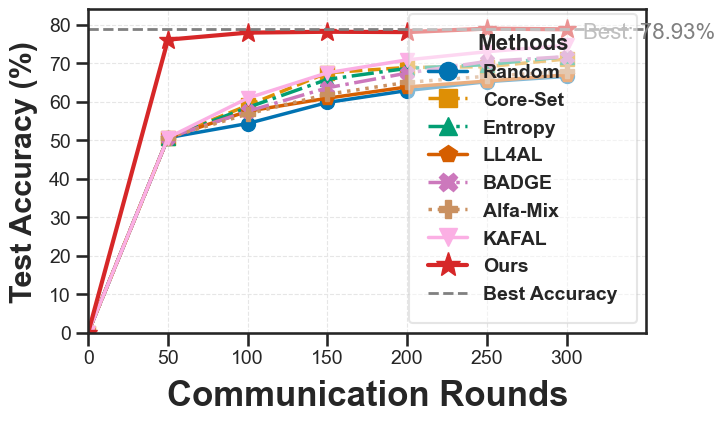

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Use a clean and professional style
plt.style.use("opinionated_tw")

# Create the plot with a larger figure size for better readability
plt.figure(figsize=(8, 5), constrained_layout=True)

# Set the aesthetic style of the plots using Seaborn's "ticks" style for a clean look
sns.set(style="ticks", context="talk", font_scale=1.3, rc={
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.color': '0.9',
    'grid.linewidth': 0.8,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
})

# Define a colorblind-friendly palette with increased contrast
palette = sns.color_palette("colorblind", 10)

# Define communication rounds (Labeling Budget in percentage)
communication_rounds = [0, 50, 100, 150, 200, 250, 300]  # Representing 0% to 35%

# Update method accuracies to start from initial_accuracy at 0%
methods = {
    'Random': [0, 50.60, 54.29, 59.76, 62.85, 65.16, 66.52],
    'Core-Set': [0, 50.60, 58.98, 67.48, 68.85, 69.04, 71.05],
    'Entropy': [0, 50.60, 58.45, 65.76, 68.61, 69.59, 71.68],
    'LL4AL': [0, 50.60, 57.48, 60.87, 63.79, 65.31, 66.94],
    'BADGE': [0, 50.60, 57.46, 63.57, 67.39, 70.42, 71.67],
    'Alfa-Mix': [0, 50.60, 56.75, 61.90, 64.98, 66.57, 67.81],
    'KAFAL': [0, 50.60, 60.88, 67.47, 70.82, 72.94, 74.60],
    'Ours': [0, 76.07, 77.89, 78.12, 78.03, 78.93, 78.76]
}

# Calculate the best accuracy achieved among all methods excluding 'Ours'
best_accuracy = max([
    max(v) for k, v in methods.items() if k != 'Ours'
] + [max(v for v in methods['Ours'] if not np.isnan(v))]
)

# Define markers and line styles for consistency
markers = {
    'Random': 'o',
    'Core-Set': 's',
    'Entropy': '^',
    'LL4AL': 'p',
    'BADGE': 'X',
    'Alfa-Mix': 'P',
    'KAFAL': 'v',
    'Ours': '*'
}

line_styles = {
    'Random': '-',
    'Core-Set': '--',
    'Entropy': '-.',
    'LL4AL': '-',
    'BADGE': '-.',
    'Alfa-Mix': ':',
    'KAFAL': '-',
    'Ours': '-'
}

linewidths = {
    'Ours': 3,  # Thicker line for 'Ours'
}

markersizes = {
    'Ours': 14,  # Larger marker for 'Ours'
}

# Assign a distinct color for 'Ours' to make it stand out
ours_color = 'tab:red'  # Choose a vibrant color not used by others

# Plot each method with distinct styles and enhanced marker visibility
for idx, (method, accuracies) in enumerate(methods.items()):
    # Handle NaN values by plotting up to the last valid point
    accuracies_np = np.array(accuracies)
    valid_indices = ~np.isnan(accuracies_np)
    x = np.array(communication_rounds)[valid_indices]
    y = accuracies_np[valid_indices]
    
    if method == 'Ours':
        plt.plot(
            x,
            y,
            label=method,
            color=ours_color,
            marker=markers[method],
            linestyle=line_styles[method],
            linewidth=linewidths.get(method, 2.5),
            markersize=markersizes.get(method, 10)
        )
    else:
        plt.plot(
            x,
            y,
            label=method,
            color=palette[idx],
            marker=markers[method],
            linestyle=line_styles[method],
            linewidth=linewidths.get(method, 2.5),
            markersize=markersizes.get(method, 10)
        )

# Highlight the best accuracy with a dashed horizontal line and annotate it
plt.axhline(y=best_accuracy, color='gray', linestyle='--', linewidth=2, label='Best Accuracy')
plt.text(
    communication_rounds[-1] + 10, best_accuracy - 1,
    f'Best: {best_accuracy}%',
    color='gray',
    verticalalignment='center',
    fontsize=16
)

# Customize axes with bold labels and appropriate limits
plt.xlabel('Communication Rounds', fontsize=25, weight='bold', loc='center')
plt.ylabel('Test Accuracy (%)', fontsize=22, weight='bold', loc='center')
#plt.title('Test Accuracy vs. Communication Cost on CIFAR-10', fontsize=24, weight='bold', loc='center')

# Ensure x-axis starts at 0 and extends slightly beyond the maximum communication round
plt.xlim(left=0, right=communication_rounds[-1] + 50)

# Ensure y-axis starts at 0 and extends slightly above the best accuracy
plt.ylim(bottom=0, top=best_accuracy + 5)

# Ensure y-axis uses integer ticks
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Customize tick parameters for better readability
plt.xticks(communication_rounds, fontsize=14)
plt.yticks(fontsize=14)

# Enhance the legend with a title and adjust its placement
plt.legend(
    title='Methods',
    loc='lower right',
    frameon=True,
    shadow=False,
    borderpad=1,
    prop={'weight': 'bold', 'size': 14},  # Makes legend texts bold
    title_fontproperties={'weight': 'bold', 'size': 16},
    framealpha=0.5
)

# Add annotations to highlight "Ours" method's early peak and no further training
# Accurate annotation pointing to (100%, 77.89%)
# plt.annotate(
#     'Early Peak',
#     xy=(100, 77.89),
#     xytext=(122, 79),
#     arrowprops=dict(facecolor=ours_color, shrink=0.05, width=2, headwidth=8),
#     fontsize=18,
#     weight='bold',
#     color=ours_color
# )
# plt.annotate(
#     'No Further Training',
#     xy=(100, 77.89),
#     xytext=(122, 73),
#     arrowprops=dict(facecolor=ours_color, shrink=0.05, width=2, headwidth=8),
#     fontsize=18,
#     weight='bold',
#     color=ours_color
# )

# Save the figure in high resolution suitable for publications
plt.savefig('CIFAR10_acc_com_full.pdf', format='pdf', dpi=600, bbox_inches='tight')

# Display the plot
plt.tight_layout()
plt.show()


C:\Users\mrhao\AppData\Local\Temp\ipykernel_41524\890679192.py:176: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


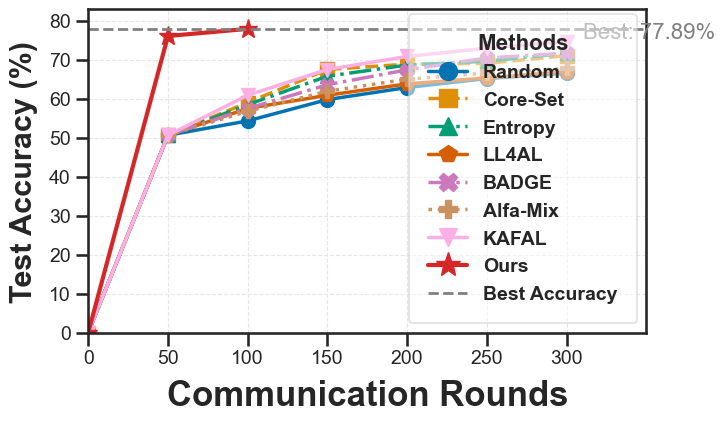

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Use a clean and professional style
plt.style.use("opinionated_tw")

# Create the plot with a larger figure size for better readability
plt.figure(figsize=(8, 5), constrained_layout=True)

# Set the aesthetic style of the plots using Seaborn's "ticks" style for a clean look
sns.set(style="ticks", context="talk", font_scale=1.3, rc={
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.color': '0.9',
    'grid.linewidth': 0.8,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
})

# Define a colorblind-friendly palette with increased contrast
palette = sns.color_palette("colorblind", 10)

# Define communication rounds (Labeling Budget in percentage)
communication_rounds = [0, 50, 100, 150, 200, 250, 300]  # Representing 0% to 35%

# Update method accuracies to start from initial_accuracy at 0%
methods = {
    'Random': [0, 50.60, 54.29, 59.76, 62.85, 65.16, 66.52],
    'Core-Set': [0, 50.60, 58.98, 67.48, 68.85, 69.04, 71.05],
    'Entropy': [0, 50.60, 58.45, 65.76, 68.61, 69.59, 71.68],
    'LL4AL': [0, 50.60, 57.48, 60.87, 63.79, 65.31, 66.94],
    'BADGE': [0, 50.60, 57.46, 63.57, 67.39, 70.42, 71.67],
    'Alfa-Mix': [0, 50.60, 56.75, 61.90, 64.98, 66.57, 67.81],
    'KAFAL': [0, 50.60, 60.88, 67.47, 70.82, 72.94, 74.60],
    'Ours': [0, 76.07, 77.89, np.nan, np.nan, np.nan, np.nan]
}

# Calculate the best accuracy achieved among all methods excluding 'Ours'
best_accuracy = max([
    max(v) for k, v in methods.items() if k != 'Ours'
] + [max(v for v in methods['Ours'] if not np.isnan(v))]
)

# Define markers and line styles for consistency
markers = {
    'Random': 'o',
    'Core-Set': 's',
    'Entropy': '^',
    'LL4AL': 'p',
    'BADGE': 'X',
    'Alfa-Mix': 'P',
    'KAFAL': 'v',
    'Ours': '*'
}

line_styles = {
    'Random': '-',
    'Core-Set': '--',
    'Entropy': '-.',
    'LL4AL': '-',
    'BADGE': '-.',
    'Alfa-Mix': ':',
    'KAFAL': '-',
    'Ours': '-'
}

linewidths = {
    'Ours': 3,  # Thicker line for 'Ours'
}

markersizes = {
    'Ours': 14,  # Larger marker for 'Ours'
}

# Assign a distinct color for 'Ours' to make it stand out
ours_color = 'tab:red'  # Choose a vibrant color not used by others

# Plot each method with distinct styles and enhanced marker visibility
for idx, (method, accuracies) in enumerate(methods.items()):
    # Handle NaN values by plotting up to the last valid point
    accuracies_np = np.array(accuracies)
    valid_indices = ~np.isnan(accuracies_np)
    x = np.array(communication_rounds)[valid_indices]
    y = accuracies_np[valid_indices]
    
    if method == 'Ours':
        plt.plot(
            x,
            y,
            label=method,
            color=ours_color,
            marker=markers[method],
            linestyle=line_styles[method],
            linewidth=linewidths.get(method, 2.5),
            markersize=markersizes.get(method, 10)
        )
    else:
        plt.plot(
            x,
            y,
            label=method,
            color=palette[idx],
            marker=markers[method],
            linestyle=line_styles[method],
            linewidth=linewidths.get(method, 2.5),
            markersize=markersizes.get(method, 10)
        )

# Highlight the best accuracy with a dashed horizontal line and annotate it
plt.axhline(y=best_accuracy, color='gray', linestyle='--', linewidth=2, label='Best Accuracy')
plt.text(
    communication_rounds[-1] + 10, best_accuracy - 1,
    f'Best: {best_accuracy}%',
    color='gray',
    verticalalignment='center',
    fontsize=16
)

# Customize axes with bold labels and appropriate limits
plt.xlabel('Communication Rounds', fontsize=25, weight='bold', loc='center')
plt.ylabel('Test Accuracy (%)', fontsize=22, weight='bold', loc='center')
#plt.title('Test Accuracy vs. Communication Cost on CIFAR-10', fontsize=24, weight='bold', loc='center')

# Ensure x-axis starts at 0 and extends slightly beyond the maximum communication round
plt.xlim(left=0, right=communication_rounds[-1] + 50)

# Ensure y-axis starts at 0 and extends slightly above the best accuracy
plt.ylim(bottom=0, top=best_accuracy + 5)

# Ensure y-axis uses integer ticks
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Customize tick parameters for better readability
plt.xticks(communication_rounds, fontsize=14)
plt.yticks(fontsize=14)

# Enhance the legend with a title and adjust its placement
plt.legend(
    title='Methods',
    loc='lower right',
    frameon=True,
    shadow=False,
    borderpad=1,
    prop={'weight': 'bold', 'size': 14},  # Makes legend texts bold
    title_fontproperties={'weight': 'bold', 'size': 16},
    framealpha=0.5
)

# Add annotations to highlight "Ours" method's early peak and no further training
# Accurate annotation pointing to (100%, 77.89%)
# plt.annotate(
#     'Early Peak',
#     xy=(100, 77.89),
#     xytext=(122, 79),
#     arrowprops=dict(facecolor=ours_color, shrink=0.05, width=2, headwidth=8),
#     fontsize=18,
#     weight='bold',
#     color=ours_color
# )
# plt.annotate(
#     'No Further Training',
#     xy=(100, 77.89),
#     xytext=(122, 73),
#     arrowprops=dict(facecolor=ours_color, shrink=0.05, width=2, headwidth=8),
#     fontsize=18,
#     weight='bold',
#     color=ours_color
# )

# Save the figure in high resolution suitable for publications
plt.savefig('CIFAR10_acc_com.pdf', format='pdf', dpi=600, bbox_inches='tight')

# Display the plot
plt.tight_layout()
plt.show()


C:\Users\mrhao\AppData\Local\Temp\ipykernel_10904\1339592172.py:176: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


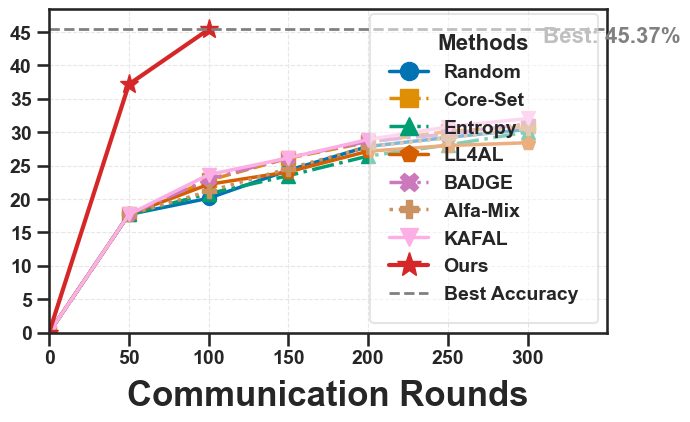

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Use a clean and professional style
plt.style.use("opinionated_tw")

# Set the aesthetic style of the plots using Seaborn's "ticks" style for a clean look
sns.set(style="ticks", context="talk", font_scale=1.3, rc={
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.color': '0.9',
    'grid.linewidth': 0.8,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
})

# Define a colorblind-friendly palette with increased contrast
palette = sns.color_palette("colorblind", 10)

# Define communication rounds (Labeling Budget in percentage)
communication_rounds = [0, 50, 100, 150, 200, 250, 300]  # Representing 0% to 35%

# Update method accuracies to start from initial_accuracy at 0%
methods = {
    'Random':   [0, 17.67, 20.10, 24.28, 27.85, 29.21, 30.41],
    'Core-Set': [0, 17.67, 22.78, 26.10, 28.49, 30.11, 30.86],
    'Entropy':  [0, 17.67, 20.79, 23.48, 26.41, 28.07, 30.01],
    'LL4AL':    [0, 17.67, 22.18, 24.05, 27.14, 27.99, 28.41],
    'BADGE':    [0, 17.67, 22.93, 26.19, 28.61, 29.71, 31.26],
    'Alfa-Mix': [0, 17.67, 21.14, 24.54, 27.79, 29.15, 30.56],
    'KAFAL':    [0, 17.67, 23.63, 26.13, 28.89, 30.79, 32.04],
    'Ours':     [0, 37.15, 45.37, np.nan, np.nan, np.nan, np.nan]
}

# Calculate the best accuracy achieved among all methods excluding 'Ours'
best_accuracy = max([
    max(v) for k, v in methods.items() if k != 'Ours'
] + [max(v for v in methods['Ours'] if not np.isnan(v))]
)

# Create the plot with a larger figure size for better readability
plt.figure(figsize=(8, 5), constrained_layout=True)

# Define markers and line styles for consistency
markers = {
    'Random': 'o',
    'Core-Set': 's',
    'Entropy': '^',
    'LL4AL': 'p',
    'BADGE': 'X',
    'Alfa-Mix': 'P',
    'KAFAL': 'v',
    'Ours': '*'
}

line_styles = {
    'Random': '-',
    'Core-Set': '--',
    'Entropy': '-.',
    'LL4AL': '-',
    'BADGE': '-.',
    'Alfa-Mix': ':',
    'KAFAL': '-',
    'Ours': '-'
}

linewidths = {
    'Ours': 3,  # Thicker line for 'Ours'
}

markersizes = {
    'Ours': 14,  # Larger marker for 'Ours'
}

# Assign a distinct color for 'Ours' to make it stand out
ours_color = 'tab:red'  # Choose a vibrant color not used by others

# Plot each method with distinct styles and enhanced marker visibility
for idx, (method, accuracies) in enumerate(methods.items()):
    # Handle NaN values by plotting up to the last valid point
    accuracies_np = np.array(accuracies)
    valid_indices = ~np.isnan(accuracies_np)
    x = np.array(communication_rounds)[valid_indices]
    y = accuracies_np[valid_indices]
    
    if method == 'Ours':
        plt.plot(
            x,
            y,
            label=method,
            color=ours_color,
            marker=markers[method],
            linestyle=line_styles[method],
            linewidth=linewidths.get(method, 2.5),
            markersize=markersizes.get(method, 10)
        )
    else:
        plt.plot(
            x,
            y,
            label=method,
            color=palette[idx],
            marker=markers[method],
            linestyle=line_styles[method],
            linewidth=linewidths.get(method, 2.5),
            markersize=markersizes.get(method, 10)
        )

# Highlight the best accuracy with a dashed horizontal line and annotate it
plt.axhline(y=best_accuracy, color='gray', linestyle='--', linewidth=2, label='Best Accuracy')
plt.text(
    communication_rounds[-1] + 10, best_accuracy - 1,
    f'Best: {best_accuracy}%',
    color='gray',
    verticalalignment='center',
    fontsize=16
)

# Customize axes with bold labels and appropriate limits
plt.xlabel('Communication Rounds', fontsize=25, weight='bold', loc='center')
#plt.ylabel('Test Accuracy (%)', fontsize=22, weight='bold', loc='center')
#plt.title('Test Accuracy vs. Communication Cost on CIFAR-10', fontsize=24, weight='bold', loc='center')

# Ensure x-axis starts at 0 and extends slightly beyond the maximum communication round
plt.xlim(left=0, right=communication_rounds[-1] + 50)

# Ensure y-axis starts at 0 and extends slightly above the best accuracy
plt.ylim(bottom=0, top=best_accuracy + 3)

# Ensure y-axis uses integer ticks
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Customize tick parameters for better readability
plt.xticks(communication_rounds, fontsize=14)
plt.yticks(fontsize=14)

# Enhance the legend with a title and adjust its placement
plt.legend(
    title='Methods',
    loc='lower right',
    frameon=True,
    shadow=False,
    borderpad=1,
    prop={'weight': 'bold', 'size': 14},  # Makes legend texts bold
    title_fontproperties={'weight': 'bold', 'size': 16},
    framealpha=0.5
)

# Add annotations to highlight "Ours" method's early peak and no further training
# Accurate annotation pointing to (100%, 77.89%)
# plt.annotate(
#     'Early Peak',
#     xy=(100, 77.89),
#     xytext=(122, 79),
#     arrowprops=dict(facecolor=ours_color, shrink=0.05, width=2, headwidth=8),
#     fontsize=18,
#     weight='bold',
#     color=ours_color
# )
# plt.annotate(
#     'No Further Training',
#     xy=(100, 77.89),
#     xytext=(122, 73),
#     arrowprops=dict(facecolor=ours_color, shrink=0.05, width=2, headwidth=8),
#     fontsize=18,
#     weight='bold',
#     color=ours_color
# )

# Save the figure in high resolution suitable for publications
plt.savefig('CIFAR100_acc_com.pdf', format='pdf', dpi=600, bbox_inches='tight')

# Display the plot
plt.tight_layout()
plt.show()


C:\Users\mrhao\AppData\Local\Temp\ipykernel_41524\3556531913.py:176: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


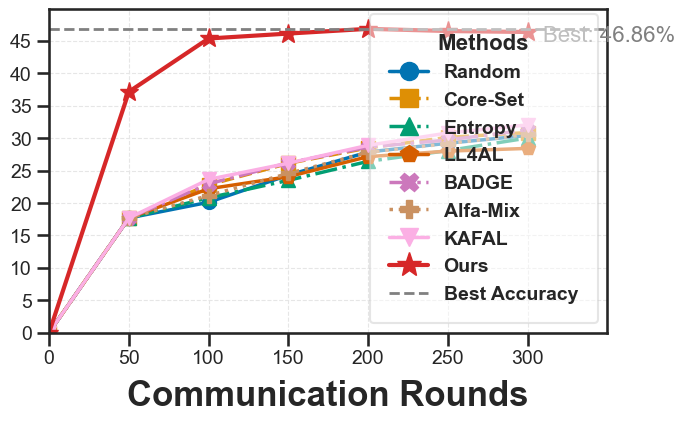

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Use a clean and professional style
plt.style.use("opinionated_tw")

# Set the aesthetic style of the plots using Seaborn's "ticks" style for a clean look
sns.set(style="ticks", context="talk", font_scale=1.3, rc={
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.color': '0.9',
    'grid.linewidth': 0.8,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
})

# Define a colorblind-friendly palette with increased contrast
palette = sns.color_palette("colorblind", 10)

# Define communication rounds (Labeling Budget in percentage)
communication_rounds = [0, 50, 100, 150, 200, 250, 300]  # Representing 0% to 35%

# Update method accuracies to start from initial_accuracy at 0%
methods = {
    'Random':   [0, 17.67, 20.10, 24.28, 27.85, 29.21, 30.41],
    'Core-Set': [0, 17.67, 22.78, 26.10, 28.49, 30.11, 30.86],
    'Entropy':  [0, 17.67, 20.79, 23.48, 26.41, 28.07, 30.01],
    'LL4AL':    [0, 17.67, 22.18, 24.05, 27.14, 27.99, 28.41],
    'BADGE':    [0, 17.67, 22.93, 26.19, 28.61, 29.71, 31.26],
    'Alfa-Mix': [0, 17.67, 21.14, 24.54, 27.79, 29.15, 30.56],
    'KAFAL':    [0, 17.67, 23.63, 26.13, 28.89, 30.79, 32.04],
    'Ours':     [0, 37.15, 45.37, 46.13, 46.86, 46.52, 46.37]
}

# Calculate the best accuracy achieved among all methods excluding 'Ours'
best_accuracy = max([
    max(v) for k, v in methods.items() if k != 'Ours'
] + [max(v for v in methods['Ours'] if not np.isnan(v))]
)

# Create the plot with a larger figure size for better readability
plt.figure(figsize=(8, 5), constrained_layout=True)

# Define markers and line styles for consistency
markers = {
    'Random': 'o',
    'Core-Set': 's',
    'Entropy': '^',
    'LL4AL': 'p',
    'BADGE': 'X',
    'Alfa-Mix': 'P',
    'KAFAL': 'v',
    'Ours': '*'
}

line_styles = {
    'Random': '-',
    'Core-Set': '--',
    'Entropy': '-.',
    'LL4AL': '-',
    'BADGE': '-.',
    'Alfa-Mix': ':',
    'KAFAL': '-',
    'Ours': '-'
}

linewidths = {
    'Ours': 3,  # Thicker line for 'Ours'
}

markersizes = {
    'Ours': 14,  # Larger marker for 'Ours'
}

# Assign a distinct color for 'Ours' to make it stand out
ours_color = 'tab:red'  # Choose a vibrant color not used by others

# Plot each method with distinct styles and enhanced marker visibility
for idx, (method, accuracies) in enumerate(methods.items()):
    # Handle NaN values by plotting up to the last valid point
    accuracies_np = np.array(accuracies)
    valid_indices = ~np.isnan(accuracies_np)
    x = np.array(communication_rounds)[valid_indices]
    y = accuracies_np[valid_indices]
    
    if method == 'Ours':
        plt.plot(
            x,
            y,
            label=method,
            color=ours_color,
            marker=markers[method],
            linestyle=line_styles[method],
            linewidth=linewidths.get(method, 2.5),
            markersize=markersizes.get(method, 10)
        )
    else:
        plt.plot(
            x,
            y,
            label=method,
            color=palette[idx],
            marker=markers[method],
            linestyle=line_styles[method],
            linewidth=linewidths.get(method, 2.5),
            markersize=markersizes.get(method, 10)
        )

# Highlight the best accuracy with a dashed horizontal line and annotate it
plt.axhline(y=best_accuracy, color='gray', linestyle='--', linewidth=2, label='Best Accuracy')
plt.text(
    communication_rounds[-1] + 10, best_accuracy - 1,
    f'Best: {best_accuracy}%',
    color='gray',
    verticalalignment='center',
    fontsize=16
)

# Customize axes with bold labels and appropriate limits
plt.xlabel('Communication Rounds', fontsize=25, weight='bold', loc='center')
#plt.ylabel('Test Accuracy (%)', fontsize=22, weight='bold', loc='center')
#plt.title('Test Accuracy vs. Communication Cost on CIFAR-10', fontsize=24, weight='bold', loc='center')

# Ensure x-axis starts at 0 and extends slightly beyond the maximum communication round
plt.xlim(left=0, right=communication_rounds[-1] + 50)

# Ensure y-axis starts at 0 and extends slightly above the best accuracy
plt.ylim(bottom=0, top=best_accuracy + 3)

# Ensure y-axis uses integer ticks
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Customize tick parameters for better readability
plt.xticks(communication_rounds, fontsize=14)
plt.yticks(fontsize=14)

# Enhance the legend with a title and adjust its placement
plt.legend(
    title='Methods',
    loc='lower right',
    frameon=True,
    shadow=False,
    borderpad=1,
    prop={'weight': 'bold', 'size': 14},  # Makes legend texts bold
    title_fontproperties={'weight': 'bold', 'size': 16},
    framealpha=0.5
)

# Add annotations to highlight "Ours" method's early peak and no further training
# Accurate annotation pointing to (100%, 77.89%)
# plt.annotate(
#     'Early Peak',
#     xy=(100, 77.89),
#     xytext=(122, 79),
#     arrowprops=dict(facecolor=ours_color, shrink=0.05, width=2, headwidth=8),
#     fontsize=18,
#     weight='bold',
#     color=ours_color
# )
# plt.annotate(
#     'No Further Training',
#     xy=(100, 77.89),
#     xytext=(122, 73),
#     arrowprops=dict(facecolor=ours_color, shrink=0.05, width=2, headwidth=8),
#     fontsize=18,
#     weight='bold',
#     color=ours_color
# )

# Save the figure in high resolution suitable for publications
plt.savefig('CIFAR100_acc_com_full.pdf', format='pdf', dpi=600, bbox_inches='tight')

# Display the plot
plt.tight_layout()
plt.show()


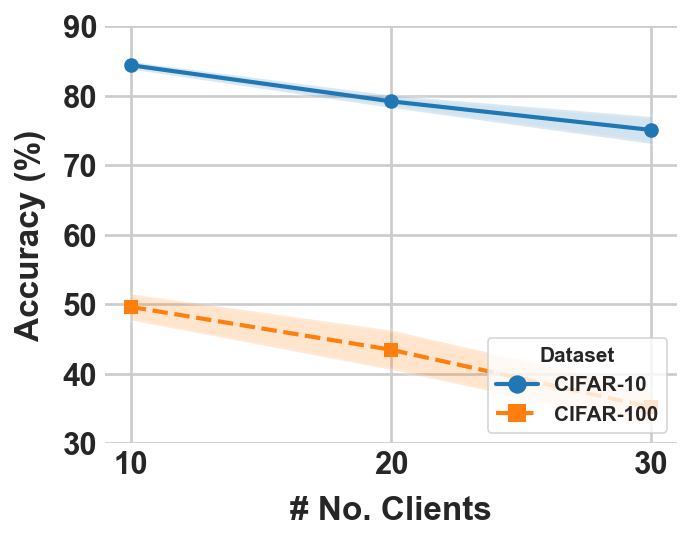

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib as mpl

# 1. Load the style first
plt.style.use("opinionated_tw")

# 2. Override font settings after
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Segoe UI"],
    "font.weight": "bold"
})

# Optional: remove top/right spines for a cleaner look
sns.set_style("whitegrid", {"axes.spines.right": False, "axes.spines.top": False})

# 3. Create some data
data = {
    "Number of Clients": [10, 20, 30],
    "CIFAR-10 Accuracy": [84.36, 79.16, 75.04],
    "CIFAR-10 Std Dev": [0.54, 0.88, 1.94],
    "CIFAR-100 Accuracy": [49.59, 43.42, 35.14],
    "CIFAR-100 Std Dev": [1.88, 2.83, 2.62]
}
df = pd.DataFrame(data)

# 4. Plot
fig, ax = plt.subplots(figsize=(4.5, 3.5), dpi=150, constrained_layout=True)

ax.plot(df["Number of Clients"], df["CIFAR-10 Accuracy"],
        marker='o', linestyle='-', linewidth=2, label='CIFAR-10')
ax.fill_between(df["Number of Clients"],
                df["CIFAR-10 Accuracy"] - df["CIFAR-10 Std Dev"],
                df["CIFAR-10 Accuracy"] + df["CIFAR-10 Std Dev"],
                alpha=0.2, linewidth=2.0)

ax.plot(df["Number of Clients"], df["CIFAR-100 Accuracy"],
        marker='s', linestyle='--', linewidth=2, label='CIFAR-100')
ax.fill_between(df["Number of Clients"],
                df["CIFAR-100 Accuracy"] - df["CIFAR-100 Std Dev"],
                df["CIFAR-100 Accuracy"] + df["CIFAR-100 Std Dev"],
                alpha=0.2, linewidth=2.0)

ax.set_xlabel("Number of Clients", fontsize=16, fontweight="bold", loc='center')
ax.set_ylabel("Accuracy (%)", fontsize=16, fontweight="bold", loc='center')
ax.set_xticks(df["Number of Clients"])
ax.tick_params(axis="both", which="major", labelsize=15)
ax.set_ylim(30, 90)

legend = ax.legend(title="Dataset", title_fontsize=10, fontsize=10, loc="lower right", frameon=True, shadow=False)
legend.get_frame().set_linewidth(0.8)


# ax.set_title("Ablation Study: Clients vs. Accuracy", fontsize=12, fontweight="bold")
plt.savefig('Ablation_Client_Amount.pdf', format='pdf', dpi=600, bbox_inches='tight')

plt.show()
